In [38]:
import glob
import pandas as pd
import os

root_dir = './xiao-data-round/'

# Obtenemos todos los folders
folders = glob.glob(os.path.join(root_dir, '*/'))
print(f'Found {len(folders)} folders.')


# Juntamos por grupos los que tienen el mismo nombre excepto el último número
# (que es el número de la serie)
grouped_folders = {}
for folder in folders:
    # Obtenemos el nombre del folder sin la ruta
    folder_name = os.path.basename(os.path.dirname(folder))
    # Obtenemos el nombre sin el número de la serie
    folder_name = folder_name[:-1]
    
    # Si no existe el grupo, lo creamos
    if folder_name not in grouped_folders:
        grouped_folders[folder_name] = []
    # Añadimos el folder al grupo
    grouped_folders[folder_name].append(folder)
    
print(f'Grouped into {len(grouped_folders)} groups.')

# Obtenemos todos los archivos .csv que se llamen igual en cada grupo bajo todo el folder
csv_files = {}
for folder_name, folders in grouped_folders.items():
    # Obtenemos todos los archivos .csv que se llamen igual en cada grupo
    csv_files[folder_name] = []
    for folder in folders:
        # Obtenemos todos los archivos .csv en el folder
        csv_files[folder_name].extend(glob.glob(os.path.join(folder, '**/*.csv')))
        
        
# Filtramos los que acaban en _monitor.csv
csv_files = {k: [f for f in v if not f.endswith('_monitor.csv')] for k, v in csv_files.items()}

print(csv_files)
    

# Aquellos que se llamen exactamente igual, los unimos en un solo dataframe
# y los guardamos en un solo archivo .csv con el nombre del mismo nombre + _merged.csv
csv_merged = {}
for folder_name, files in csv_files.items():
    # Obtenemos el nombre del primer archivo
    file_name = os.path.basename(files[0])
    # Obtenemos el nombre del folder
    folder_name = os.path.dirname(files[0])
    
    # Si no existe el grupo, lo creamos
    if file_name not in csv_merged:
        csv_merged[file_name] = []
    
    # Añadimos el archivo al grupo
    csv_merged[file_name].extend(files)
    
# Unimos los archivos en un solo dataframe
df = pd.DataFrame()
for file_name, files in csv_merged.items():
    # Unimos los archivos en un solo dataframe
    df_temp = pd.concat([pd.read_csv(file) for file in files])
    
    # Añadimos el dataframe al dataframe final
    df = pd.concat([df, df_temp])
    
# Guardamos el dataframe en un archivo .csv
df.to_csv(os.path.join(root_dir, 'merged_data.csv'), index=False)
print(f'Saved merged data to {os.path.join(root_dir, "merged_data.csv")}')


Found 35 folders.
Grouped into 7 groups.
{'thread_12_round_': ['./xiao-data-round\\thread_12_round_1\\load_12500\\_12500_12.csv', './xiao-data-round\\thread_12_round_1\\load_25000\\_25000_12.csv', './xiao-data-round\\thread_12_round_1\\load_37500\\_37500_12.csv', './xiao-data-round\\thread_12_round_1\\load_50000\\_50000_12.csv', './xiao-data-round\\thread_12_round_1\\load_62500\\_62500_12.csv', './xiao-data-round\\thread_12_round_1\\load_75000\\_75000_12.csv', './xiao-data-round\\thread_12_round_2\\load_12500\\_12500_12.csv', './xiao-data-round\\thread_12_round_2\\load_25000\\_25000_12.csv', './xiao-data-round\\thread_12_round_2\\load_37500\\_37500_12.csv', './xiao-data-round\\thread_12_round_2\\load_50000\\_50000_12.csv', './xiao-data-round\\thread_12_round_2\\load_62500\\_62500_12.csv', './xiao-data-round\\thread_12_round_2\\load_75000\\_75000_12.csv', './xiao-data-round\\thread_12_round_3\\load_12500\\_12500_12.csv', './xiao-data-round\\thread_12_round_3\\load_25000\\_25000_12.csv',

     load  threads  events_seconds_mean  events_seconds_std  \
0   12500        1             1040.078            9.026797   
5   25000        1              406.338            1.729744   
10  37500        1              232.398            2.648633   
15  50000        1              156.052            0.922245   
20  62500        1              114.986            0.370923   
25  75000        1               89.090            0.314960   
1   12500        2             2015.172           19.382540   
6   25000        2              739.282            2.803272   
11  37500        2              419.142            0.633669   
16  50000        2              283.632            0.683532   
21  62500        2              207.272            2.053197   
26  75000        2              162.110            0.327536   
2   12500        3             2538.650            3.479799   
7   25000        3              981.670            1.854346   
12  37500        3              562.128            0.82

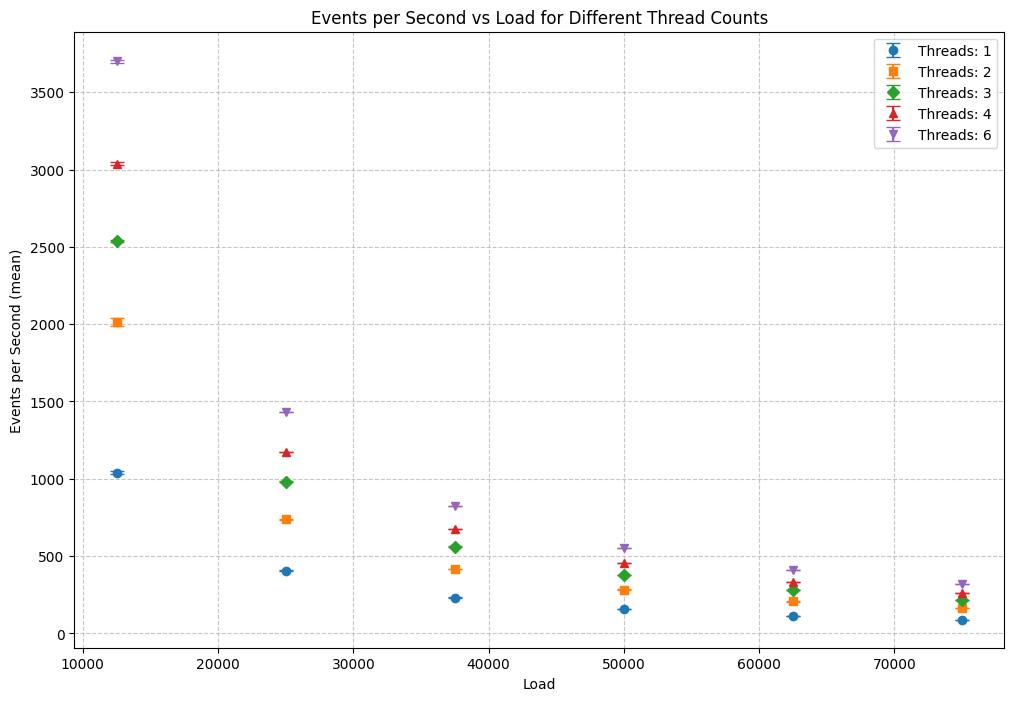

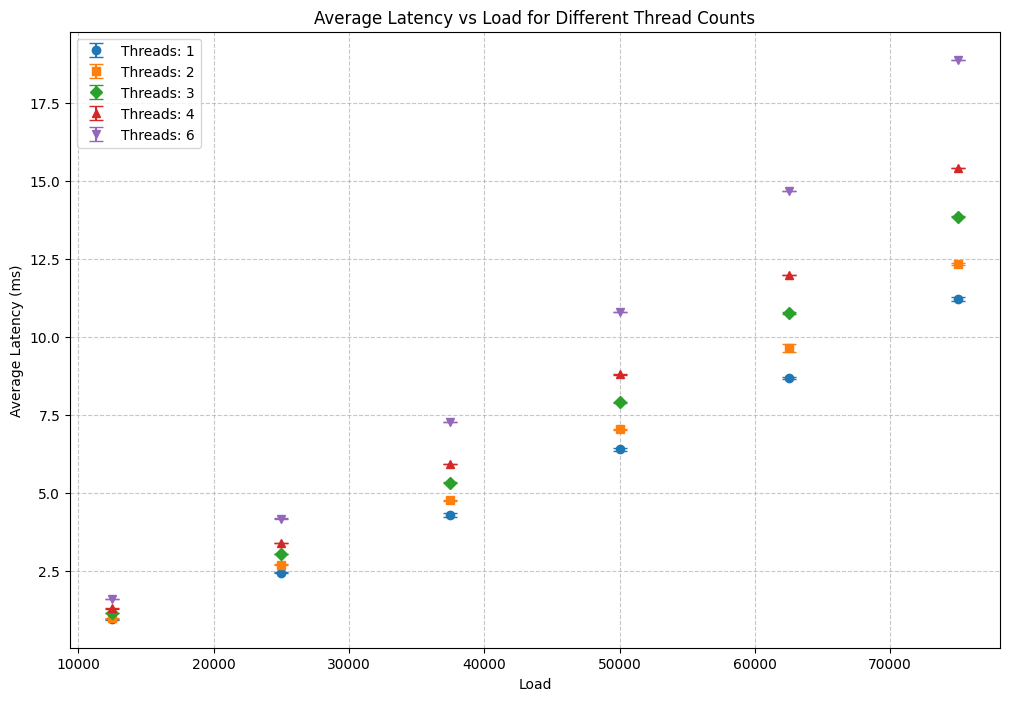

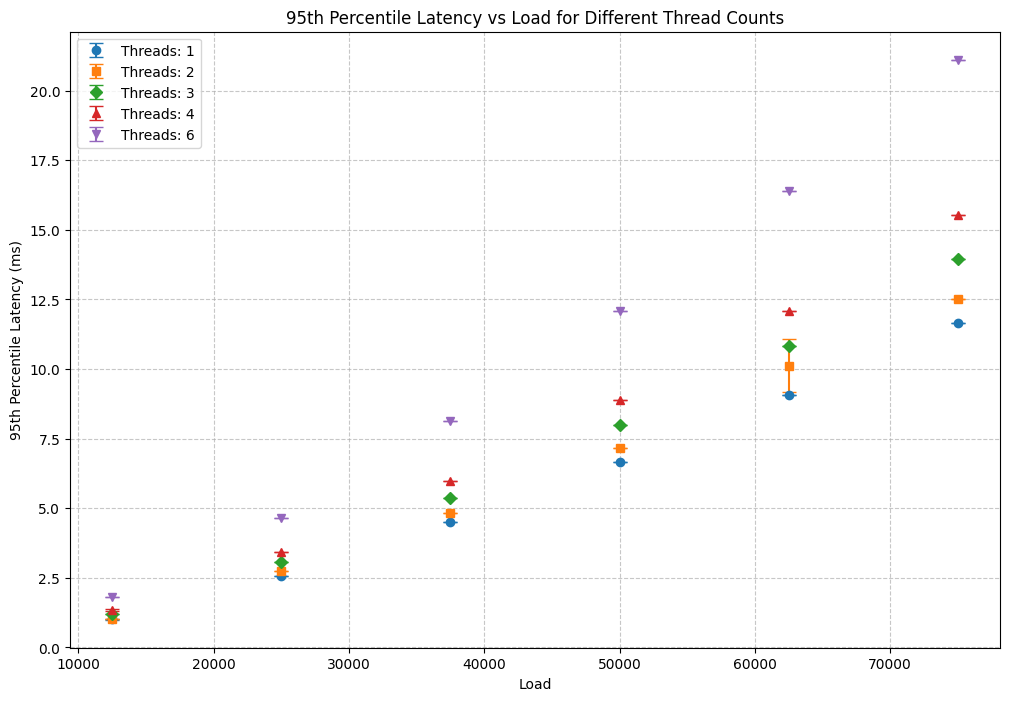

In [40]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Abrimos el archivo .csv y lo mostramos
df = pd.read_csv(os.path.join(root_dir, 'merged_data.csv'))

# Eliminar toda fila con threads > 8
df = df[df['threads'] <= 8]

# Agrupar por load y threads
grouped = df.groupby(['load', 'threads'])

# Columnas para las que queremos calcular estadísticas
metrics = ['events_seconds', 'latency_min', 'latency_avg', 'latency_max', 'latency_95th']

# Calcular media, desviación estándar e intervalo de confianza
results = []
confidence_level = 0.95  # 95% de intervalo de confianza

for (load, threads), group in grouped:
    row = {'load': load, 'threads': threads}
    
    for metric in metrics:
        values = group[metric].values
        mean = values.mean()
        std = values.std()
        
        # Calcular intervalo de confianza
        n = len(values)
        t_value = stats.t.ppf((1 + confidence_level) / 2, n - 1)
        ci = t_value * (std / np.sqrt(n))
        
        row[f'{metric}_mean'] = mean
        row[f'{metric}_std'] = std
        row[f'{metric}_ci_lower'] = mean - ci
        row[f'{metric}_ci_upper'] = mean + ci
    
    results.append(row)

# Crear DataFrame con los resultados
df_stats = pd.DataFrame(results)

# Ordenar por load y threads para facilitar la interpretación
df_stats = df_stats.sort_values(by=['threads', 'load'])

# Mostrar los resultados
print(df_stats)

# to csv
df_stats.to_csv(os.path.join(root_dir, 'merged_data_stats.csv'), index=False)

# Ejemplo de visualización: events_seconds por load y threads
plt.figure(figsize=(12, 8))

# Agrupar por threads para visualizar
thread_values = sorted(df_stats['threads'].unique())
markers = ['o', 's', 'D', '^', 'v', 'p', '*']

for i, thread in enumerate(thread_values):
    subset = df_stats[df_stats['threads'] == thread]
    plt.errorbar(
        subset['load'], 
        subset['events_seconds_mean'],
        yerr=subset['events_seconds_mean'] - subset['events_seconds_ci_lower'],
        fmt=markers[i % len(markers)],
        capsize=5,
        label=f'Threads: {thread}'
    )

plt.xlabel('Load')
plt.ylabel('Events per Second (mean)')
plt.title('Events per Second vs Load for Different Thread Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Latency visualización
plt.figure(figsize=(12, 8))
# Create plot for average latency
for i, thread in enumerate(thread_values):
    subset = df_stats[df_stats['threads'] == thread]
    plt.errorbar(
        subset['load'], 
        subset['latency_avg_mean'],
        yerr=subset['latency_avg_mean'] - subset['latency_avg_ci_lower'],
        fmt=markers[i % len(markers)],
        capsize=5,
        label=f'Threads: {thread}'
    )

plt.xlabel('Load')
plt.ylabel('Average Latency (ms)')
plt.title('Average Latency vs Load for Different Thread Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Also create a plot for 95th percentile latency
plt.figure(figsize=(12, 8))
for i, thread in enumerate(thread_values):
    subset = df_stats[df_stats['threads'] == thread]
    plt.errorbar(
        subset['load'], 
        subset['latency_95th_mean'],
        yerr=subset['latency_95th_mean'] - subset['latency_95th_ci_lower'],
        fmt=markers[i % len(markers)],
        capsize=5,
        label=f'Threads: {thread}'
    )

plt.xlabel('Load')
plt.ylabel('95th Percentile Latency (ms)')
plt.title('95th Percentile Latency vs Load for Different Thread Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()